# Land Cover Segmentation Using U-Net Architecture on the DeepGlobe Dataset

---


This project focuses on land cover segmentation using the U-Net model. The goal of the project is to classify and segment different types of land such as urban areas, agricultural land, forests, water, and others using satellite images. I used DeepGlobe dataset, which contains a variety of satellite images along with corresponding masks defining the different land types. The project covers all steps from downloading and preparing the data, image augmentation, to training and evaluating the model. Each of these steps is described below.

## Import necessary libraries


In [ ]:
from google.colab import files
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
from scipy.spatial import KDTree

## Loading dataset
The dataset is downloaded from Kaggle. It is the DeepGlobe Land Cover Classification dataset. The DeepGlobe dataset is used for automatic land cover classification and segmentation. This dataset is part of the DeepGlobe challenge for land cover classification, aimed at improving sustainable development, autonomous agriculture, and urban planning through automatic land cover classification.

In [ ]:
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset

!unzip deepglobe-land-cover-classification-dataset.zip -d ./deepglobe_dataset

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
 99% 2.72G/2.74G [00:45<00:00, 122MB/s]
100% 2.74G/2.74G [00:46<00:00, 63.9MB/s]
Archive:  deepglobe-land-cover-classification-dataset.zip
  inflating: ./deepglobe_dataset/class_dict.csv  
  inflating: ./deepglobe_dataset/metadata.csv  
  inflating: ./deepglobe_dataset/test/100877_sat.jpg  
  inflating: ./deepglobe_dataset/test/103215_sat.jpg  
  inflating: ./deepglobe_dataset/test/103742_sat.jpg  
  inflating: ./deepglobe_dataset/test/110224_sat.jpg  
  inflating: ./deepglobe_dataset/test/112946_sat.jpg  
  inflating: ./deepglobe_dataset/test/114542_sat.jpg  
  inflating: ./deepglobe_dataset/test/115800_sat.jpg  
  inflating: ./deepglobe_dataset/test/118757_sat.jpg  
  inflating: ./deepglobe_dataset/test/119896_sat.jpg  
  inflating: ./deepglobe_dataset/test/120939_sat.jpg  
  inflating: ./deepglobe_dataset/test/121151_sat.jpg  
  inflat

#### Data Characteristics
* The training set contains 803 RGB satellite images.
* Each image has dimensions of 2448x2448 pixels.
* The pixel resolution is 50 cm.
* The dataset also includes 171 validation images and 172 test images, but test images do not contain masks.

#### Sources
* Images are collected by satellites from DigitalGlobe.


#### Labels and Masks
Each satellite image has a corresponding annotation mask, which is an RGB image with 7 classes of land cover. Each class has a specific color code:

* <span style="background-color: rgb(0, 255, 255); width: 20px; height: 20px; display: inline-block;"></span> RGB (0, 255, 255) -> Urban Land – urban settlements, man-made areas
* <span style="background-color: rgb(255, 255, 0); width: 20px; height: 20px; display: inline-block;"></span> RGB (255, 255, 0) ->Agricultural Land – farms, fields, orchards, vineyards
* <span style="background-color: rgb(255, 0, 255); width: 20px; height: 20px; display: inline-block;"></span> RGB (255, 0, 255) -> Grassland – non-forest, non-agricultural green land
* <span style="background-color: rgb(0, 255, 0); width: 20px; height: 20px; display: inline-block;"></span> RGB (0, 255, 0) -> Forest Land – areas with high tree canopy density
* <span style="background-color: rgb(0, 0, 255); width: 20px; height: 20px; display: inline-block;"></span> RGB (0, 0, 255) -> Water – rivers, lakes, oceans
* <span style="background-color: rgb(255, 255, 255); width: 20px; height: 20px; display: inline-block;"></span> RGB (255, 255, 255) -> Barren Land – mountains, deserts, beaches without vegetation 
* <span style="background-color: rgb(0, 0, 0); width: 20px; height: 20px; display: inline-block;"></span> RGB (0, 0, 0) -> Unknown – clouds and unknown areas



## Data Preparation - Preprocessing
This cell sets the parameters and functions for loading, processing, and augmenting satellite images and their corresponding masks. Data loading is done from the metadata CSV file, while augmentation is performed using horizontal flipping and random rotations of images. Conversion between colors and classes is enabled using KDTree for fast mapping. Finally, the data is prepared for model training. A visualization of the prepared data is done to verify that the masks are correctly loaded and processed.
#### Data Preprocessing Results
After processing the original data,I obtain 2409 images for input into the model. After splitting into training, test, and validation sets, I have:

* 1734 images for model training
* 193 images for validation
* 482 images for testing model performance
In the next section, the complete training process using the U-Net architecture is performed.



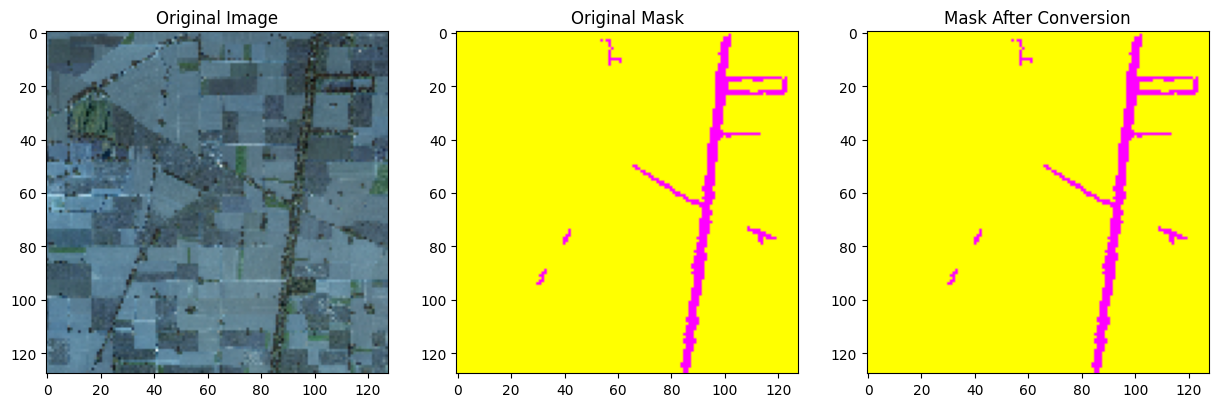

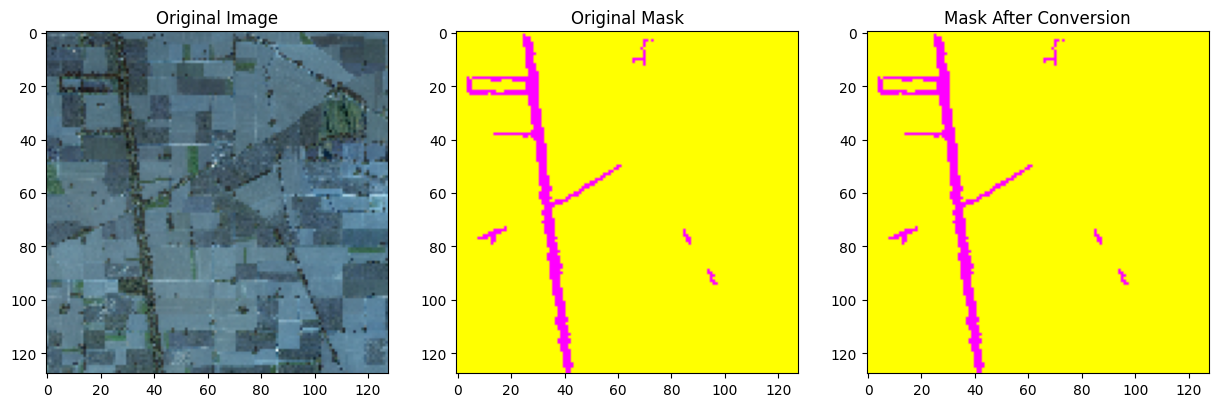

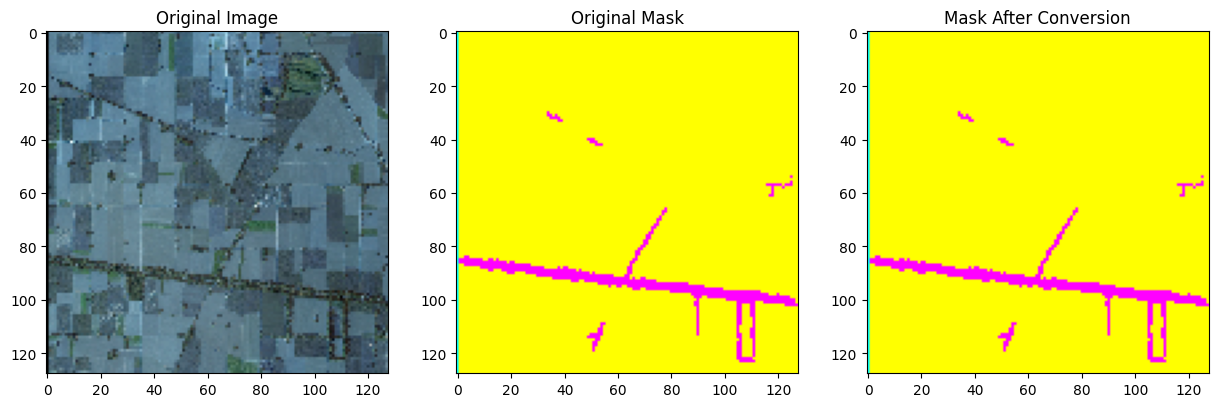

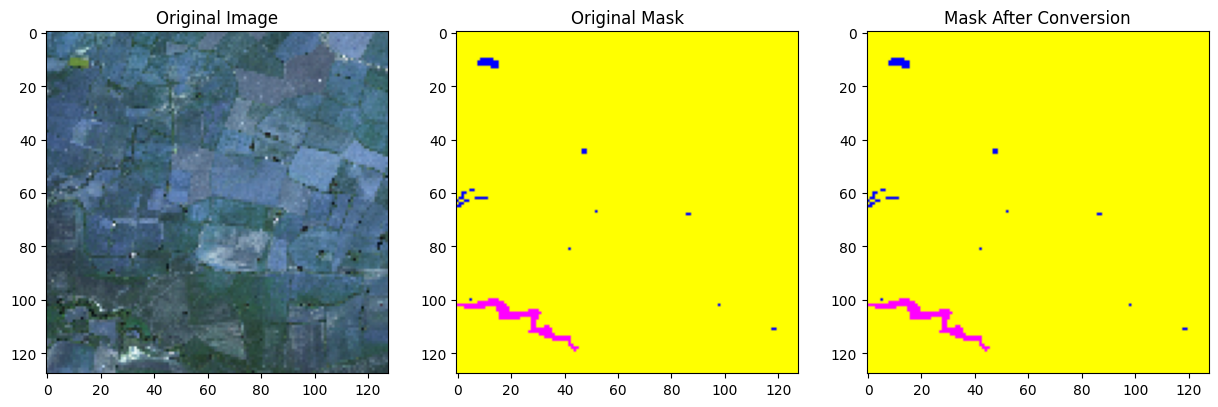

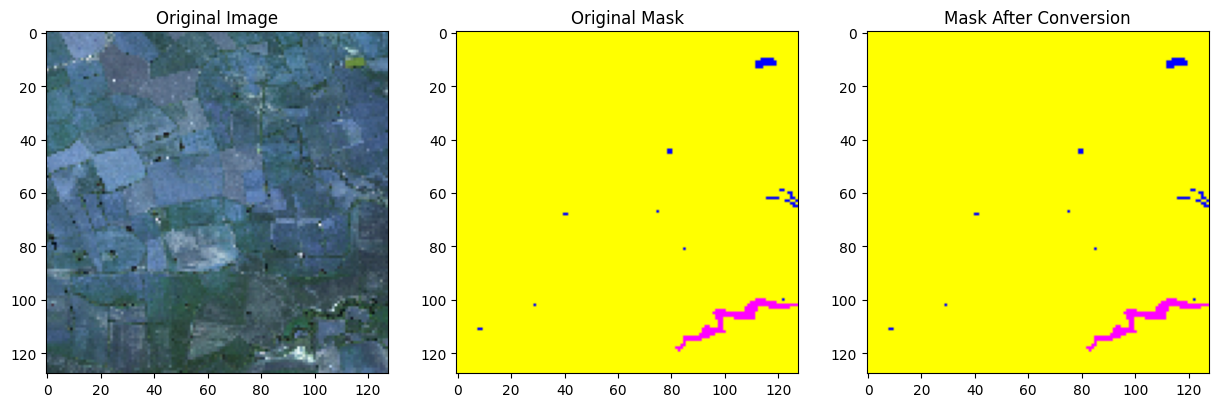

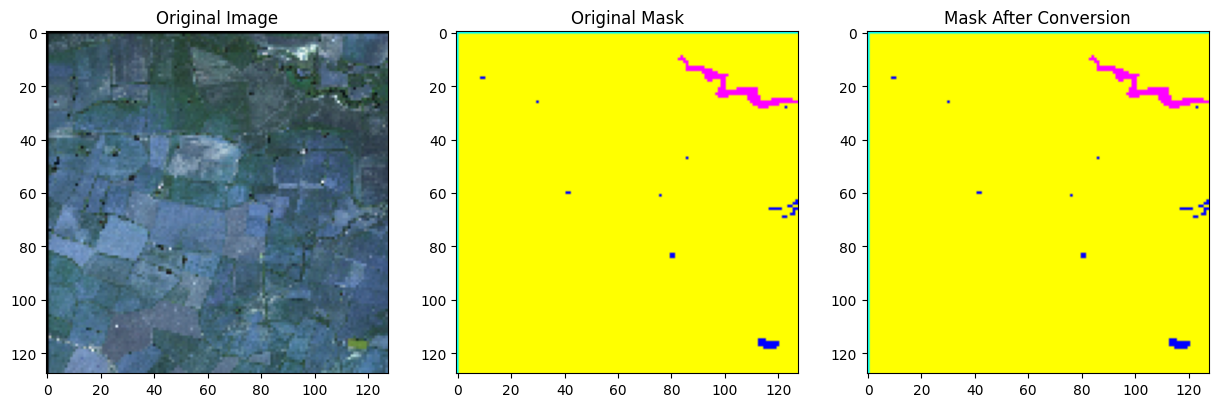

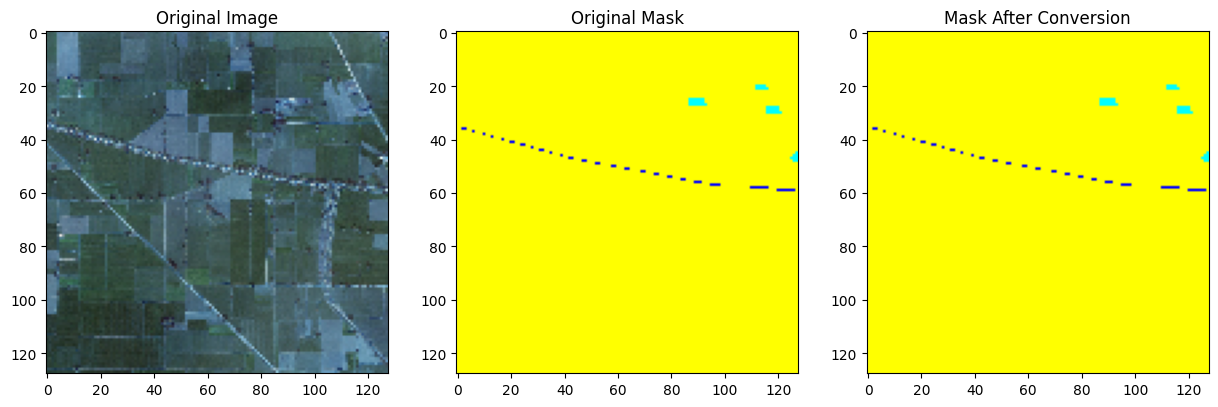

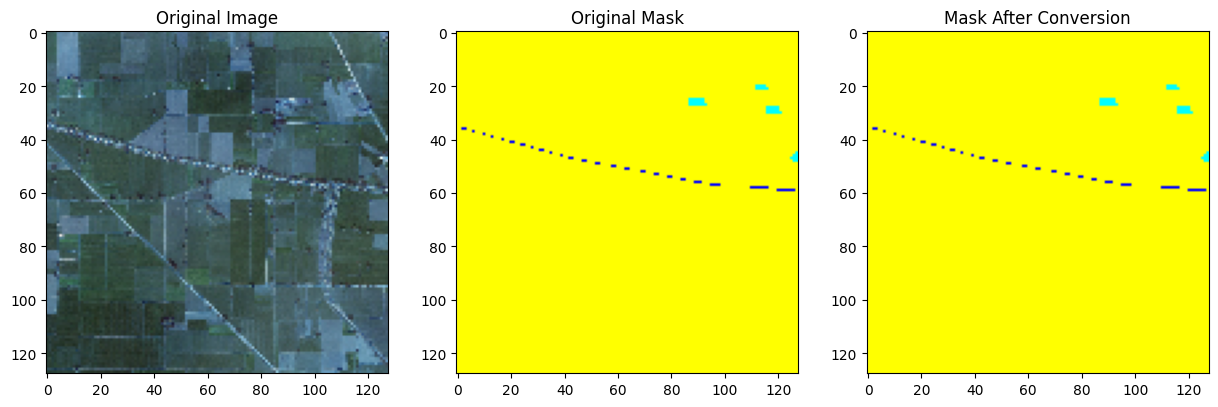

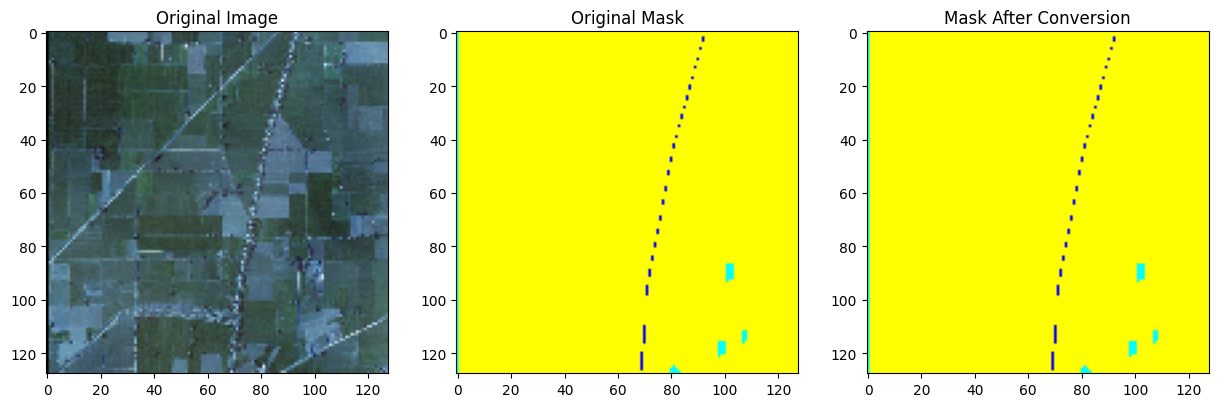

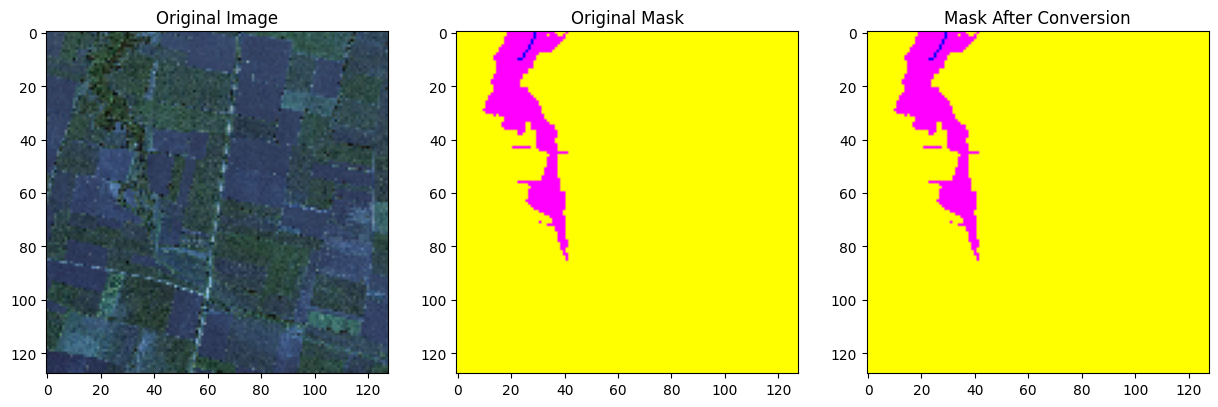

Shape of X: (2409, 128, 128, 3)
Shape of Y: (2409, 128, 128)
Shape of X train: (1734, 128, 128, 3)
Shape of Y train: (1734, 128, 128)
Shape of X test: (482, 128, 128, 3)
Shape of Y test: (482, 128, 128)
Shape of X val: (193, 128, 128, 3)
Shape of Y val: (193, 128, 128)


In [ ]:
# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CLASSES = 7
IMG_CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

class_to_color = {
    0: (0, 255, 255),   # Urban land
    1: (255, 255, 0),   # Agriculture land
    2: (255, 0, 255),   # Rangeland
    3: (0, 255, 0),     # Forest land
    4: (0, 0, 255),     # Water
    5: (255, 255, 255), # Barren land
    6: (0, 0, 0)        # Unknown
}

color_to_class = {
        (0, 255, 255): 0,   # Urban land
        (255, 255, 0): 1,   # Agriculture land
        (255, 0, 255): 2,   # Rangeland
        (0, 255, 0): 3,     # Forest land
        (0, 0, 255): 4,     # Water
        (255, 255, 255): 5, # Barren land
        (0, 0, 0): 6        # Unknown
    }

metadata = pd.read_csv('./deepglobe_dataset/metadata.csv')

# Filter the DataFrame to include only rows where 'split' is 'train'
train_data = metadata[metadata['split'] == 'train']

# Define augmentation
def random_horizontal_flip(image, mask):
    if random.random() < 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    return image, mask

def random_rotation(image, mask):
    angle = random.choice([90, 180, 270])  # Randomly choose 90, 180, or 270 degrees
    M = cv2.getRotationMatrix2D((IMG_WIDTH // 2, IMG_HEIGHT // 2), angle, 1)
    image = cv2.warpAffine(image, M, (IMG_WIDTH, IMG_HEIGHT), flags=cv2.INTER_LINEAR)
    mask = cv2.warpAffine(mask, M, (IMG_WIDTH, IMG_HEIGHT), flags=cv2.INTER_NEAREST)
    return image, mask

def augment_image_and_mask(image, mask):
    image_horizontal, mask_horizontal = random_horizontal_flip(image, mask)
    image_rotation, mask_rotation = random_rotation(image, mask)
    return image_horizontal, mask_horizontal, image_rotation, mask_rotation

# Function to map RGB colors to class indices
def map_colors_to_classes(mask, color_to_class, kdtree, class_labels):
    shape = mask.shape[:2]
    mask = mask.reshape(-1, 3)
    _, idx = kdtree.query(mask)  # Query KDTree for nearest color index
    class_indices = class_labels[idx]  # Map to class indices
    return class_indices.reshape(shape)  # Reshape back to original mask shape

# Function to convert class indices back to RGB
def class_indices_to_rgb(mask_indices, class_to_color):
    height, width = mask_indices.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    for cls, rgb in class_to_color.items():
        rgb_image[mask_indices == cls] = rgb
    return rgb_image

# Loading and preprocessing images and masks
def load_data(data, img_height, img_width, augment=False):
    images = []
    masks = []

    color_to_class = {
        (0, 255, 255): 0,   # Urban land
        (255, 255, 0): 1,   # Agriculture land
        (255, 0, 255): 2,   # Rangeland
        (0, 255, 0): 3,     # Forest land
        (0, 0, 255): 4,     # Water
        (255, 255, 255): 5, # Barren land
        (0, 0, 0): 6        # Unknown
    }

    # Create a KDTree (quick color mapping)
    colors = np.array(list(color_to_class.keys()))
    class_labels = np.array(list(color_to_class.values()))
    kdtree = KDTree(colors)

    for _, row in data.iterrows():
        # Load and resize image
        img = cv2.imread('./deepglobe_dataset/' + row['sat_image_path'])
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.0  # Normalize image

        # Load and resize mask
        mask = cv2.imread('./deepglobe_dataset/' + row['mask_path'], cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        mask = cv2.resize(mask, (img_width, img_height))

        # Convert RGB values to class indices
        mask_indices = map_colors_to_classes(mask, color_to_class, kdtree, class_labels)

        images.append(img)
        masks.append(mask_indices)

        if augment:
            img_aug_horizontal, mask_indices_aug_horizontal, img_aug_rotation, mask_indices_aug_rotation = augment_image_and_mask(img, mask_indices)
            images.append(img_aug_horizontal)
            masks.append(mask_indices_aug_horizontal)
            images.append(img_aug_rotation)
            masks.append(mask_indices_aug_rotation)

    images = np.array(images)
    masks = np.array(masks)

    return images, masks

# Load data with augmentation for training data
X, Y = load_data(train_data, IMG_HEIGHT, IMG_WIDTH, augment=True)

# Visualize a sample of the images, masks, and conversions after preprocessing
def visualize_data(images, masks, class_to_color):
    for i in range(10):
        img = images[i]
        mask_indices = masks[i]
        mask_rgb = class_indices_to_rgb(mask_indices, class_to_color)

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(img)

        plt.subplot(1, 3, 2)
        plt.title("Original Mask")
        original_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
        for rgb, cls in color_to_class.items():
            original_mask[np.all(mask_rgb == rgb, axis=-1)] = rgb
        plt.imshow(original_mask)

        plt.subplot(1, 3, 3)
        plt.title("Mask After Conversion")
        plt.imshow(mask_rgb)

        plt.show()

visualize_data(X, Y, class_to_color)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# Split data into training, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("Shape of X train:", X_train.shape)
print("Shape of Y train:", y_train.shape)
print("Shape of X test:", X_test.shape)
print("Shape of Y test:", y_test.shape)
print("Shape of X val:", X_val.shape)
print("Shape of Y val:", y_val.shape)


In the next section, the complete training process of the model using the U-Net architecture has been implemented.

#### Dataset Preparation
First, I have the LandCoverDataset class, which inherits from the dataset and contains the image and mask data. This class also performs the conversion of images into the CHW format required for processing in PyTorch.

Creating datasets and data loaders: Datasets for training, testing, and validation are created using the LandCoverDataset class and then passed through the DataLoader for batching and permutation.

#### Defining the U-Net Model
U-Net is a convolutional neural network used for image segmentation. The UNet class implements an encoder-decoder architecture with additional convolutional blocks. The architecture consists of two parts: the encoder, which extracts features from the input image by applying convolutional filters to detect various image characteristics, and the decoder, whose goal is to reconstruct the image to its original resolution using features from the encoder. Additionally, I have skip connections between corresponding encoder and decoder layers, allowing the decoder to use high-resolution features generated by the encoder, improving segmentation accuracy.

The U-Net model is set on the available device (CPU or GPU), the loss is computed using CrossEntropyLoss, and optimization is performed with the Adam optimizer.

#### Model Training and Validation
The loop goes through epochs, trains the model on the train set, computes loss and accuracy, and then evaluates the model on the validation set. After each epoch, the loss and accuracy results for training and validation are displayed.


In [ ]:
# Define dataset class
class LandCoverDataset(Dataset):
    def __init__(self, images, masks, num_classes):
        self.images = images
        self.masks = masks
        self.num_classes = num_classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].transpose((2, 0, 1))  # Change from HWC to CHW format
        mask = self.masks[idx]
        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

# Create train, test and val datasets and their dataloaders
train_dataset = LandCoverDataset(X_train, y_train, NUM_CLASSES)
test_dataset = LandCoverDataset(X_test, y_test, NUM_CLASSES)
val_dataset = LandCoverDataset(X_val, y_val, NUM_CLASSES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define U-Net model
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.encoder5 = self.conv_block(512, 1024)

        self.center = self.conv_block(1024, 2048)

        self.decoder5 = self.conv_block(2048 + 1024, 1024)
        self.decoder4 = self.conv_block(1024 + 512, 512)
        self.decoder3 = self.conv_block(512 + 256, 256)
        self.decoder2 = self.conv_block(256 + 128, 128)
        self.decoder1 = self.conv_block(128 + 64, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.functional.max_pool2d(e1, 2))
        e3 = self.encoder3(nn.functional.max_pool2d(e2, 2))
        e4 = self.encoder4(nn.functional.max_pool2d(e3, 2))
        e5 = self.encoder5(nn.functional.max_pool2d(e4, 2))

        center = self.center(nn.functional.max_pool2d(e5, 2))

        d5 = self.decoder5(torch.cat([nn.functional.interpolate(center, scale_factor=2, mode='bilinear', align_corners=True), e5], 1))
        d4 = self.decoder4(torch.cat([nn.functional.interpolate(d5, scale_factor=2, mode='bilinear', align_corners=True), e4], 1))
        d3 = self.decoder3(torch.cat([nn.functional.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=True), e3], 1))
        d2 = self.decoder2(torch.cat([nn.functional.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=True), e2], 1))
        d1 = self.decoder1(torch.cat([nn.functional.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True), e1], 1))

        return self.final(d1)

# Setting up model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop with validation
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += masks.nelement()
        train_correct += (predicted == masks).sum().item()

    train_accuracy = train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += masks.nelement()
            val_correct += (predicted == masks).sum().item()

    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

print("Training complete!")

Epoch 1/100, Train Loss: 1.5594, Train Accuracy: 0.5531, Val Loss: 1.4189, Val Accuracy: 0.6080
Epoch 2/100, Train Loss: 1.3276, Train Accuracy: 0.5774, Val Loss: 1.2915, Val Accuracy: 0.6080
Epoch 3/100, Train Loss: 1.2063, Train Accuracy: 0.5843, Val Loss: 1.1263, Val Accuracy: 0.6304
Epoch 4/100, Train Loss: 1.1060, Train Accuracy: 0.6173, Val Loss: 1.0646, Val Accuracy: 0.6515
Epoch 5/100, Train Loss: 1.0593, Train Accuracy: 0.6398, Val Loss: 0.9967, Val Accuracy: 0.6811
Epoch 6/100, Train Loss: 0.9942, Train Accuracy: 0.6730, Val Loss: 1.0240, Val Accuracy: 0.6599
Epoch 7/100, Train Loss: 1.0011, Train Accuracy: 0.6701, Val Loss: 0.9781, Val Accuracy: 0.6731
Epoch 8/100, Train Loss: 0.9624, Train Accuracy: 0.6840, Val Loss: 0.9422, Val Accuracy: 0.6998
Epoch 9/100, Train Loss: 0.9238, Train Accuracy: 0.7069, Val Loss: 0.9237, Val Accuracy: 0.7066
Epoch 10/100, Train Loss: 0.9042, Train Accuracy: 0.7149, Val Loss: 0.8637, Val Accuracy: 0.7432
Epoch 11/100, Train Loss: 0.8969, Train

Saving the model.

In [ ]:
torch.save(model.state_dict(), 'unet_land_cover_best.pth')

### Metric Calculation
These metrics will be later called during model testing to check the efficiency and performance of the model.

In [ ]:
# Function to compute performance metrics
def compute_metrics(pred, target, num_classes):
    pred = pred.flatten()
    target = target.flatten()

    iou_scores = []
    f1_scores = []

    for cls in range(num_classes):
        intersection = ((pred == cls) & (target == cls)).sum()
        union = ((pred == cls) | (target == cls)).sum()
        tp = intersection
        fp = ((pred == cls) & (target != cls)).sum()
        fn = ((pred != cls) & (target == cls)).sum()
        if union != 0:
            iou = intersection / union
        else:
            iou = 0
        if tp + fp + fn != 0:
            f1 = 2 * tp / (2 * tp + fp + fn)
        else:
            f1 = 0

        iou_scores.append(iou)
        f1_scores.append(f1)

    return np.mean(iou_scores), np.mean(f1_scores)

## Model Testing
Testing was done on the test dataset. The testing results are printed, and based on them, it can be concluded that the model has solid performance.

#### IoU (Intersection over Union)
The IoU metric gives a result of 63%. This metric measures the average overlap between my predicted regions (masks) and the actual regions (target labels). This result means that, on average, 63% of my predicted regions overlap with the actual regions.

#### F1 Score
The F1 score combines precision (how accurately the model found relevant instances) and recall (how many of the actual instances were found by the model). My result of 76% indicates the average precision and recall of my model.

In [ ]:
# Evaluation on the test set with additional IoU and F1-score
def evaluate_model_on_test(model, test_loader, criterion, device, num_classes):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += masks.nelement()
            test_correct += (predicted == masks).sum().item()

            all_predictions.append(predicted.cpu().numpy())
            all_labels.append(masks.cpu().numpy())

    test_accuracy = test_correct / test_total

    # Flatten the list of arrays
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    # Compute IoU and F1 score using your function
    avg_iou, avg_f1 = compute_metrics(all_predictions, all_labels, num_classes)

    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Average IoU: {avg_iou:.4f}")
    print(f"Test Average F1 Score: {avg_f1:.4f}")

In [ ]:
evaluate_model_on_test(model, test_loader, criterion, device, NUM_CLASSES)

Test Loss: 0.6786
Test Accuracy: 0.8518
Test Average IoU: 0.6334
Test Average F1 Score: 0.7590


## Data Visualization After Testing
Based on the obtained outputs, I can see that my model performs quite well in finding the appropriate regions. There are errors, which occur more frequently when regions occupy a small area (few pixels), and the model fails to register them, as well as errors on the borders (where one region ends and another starts).


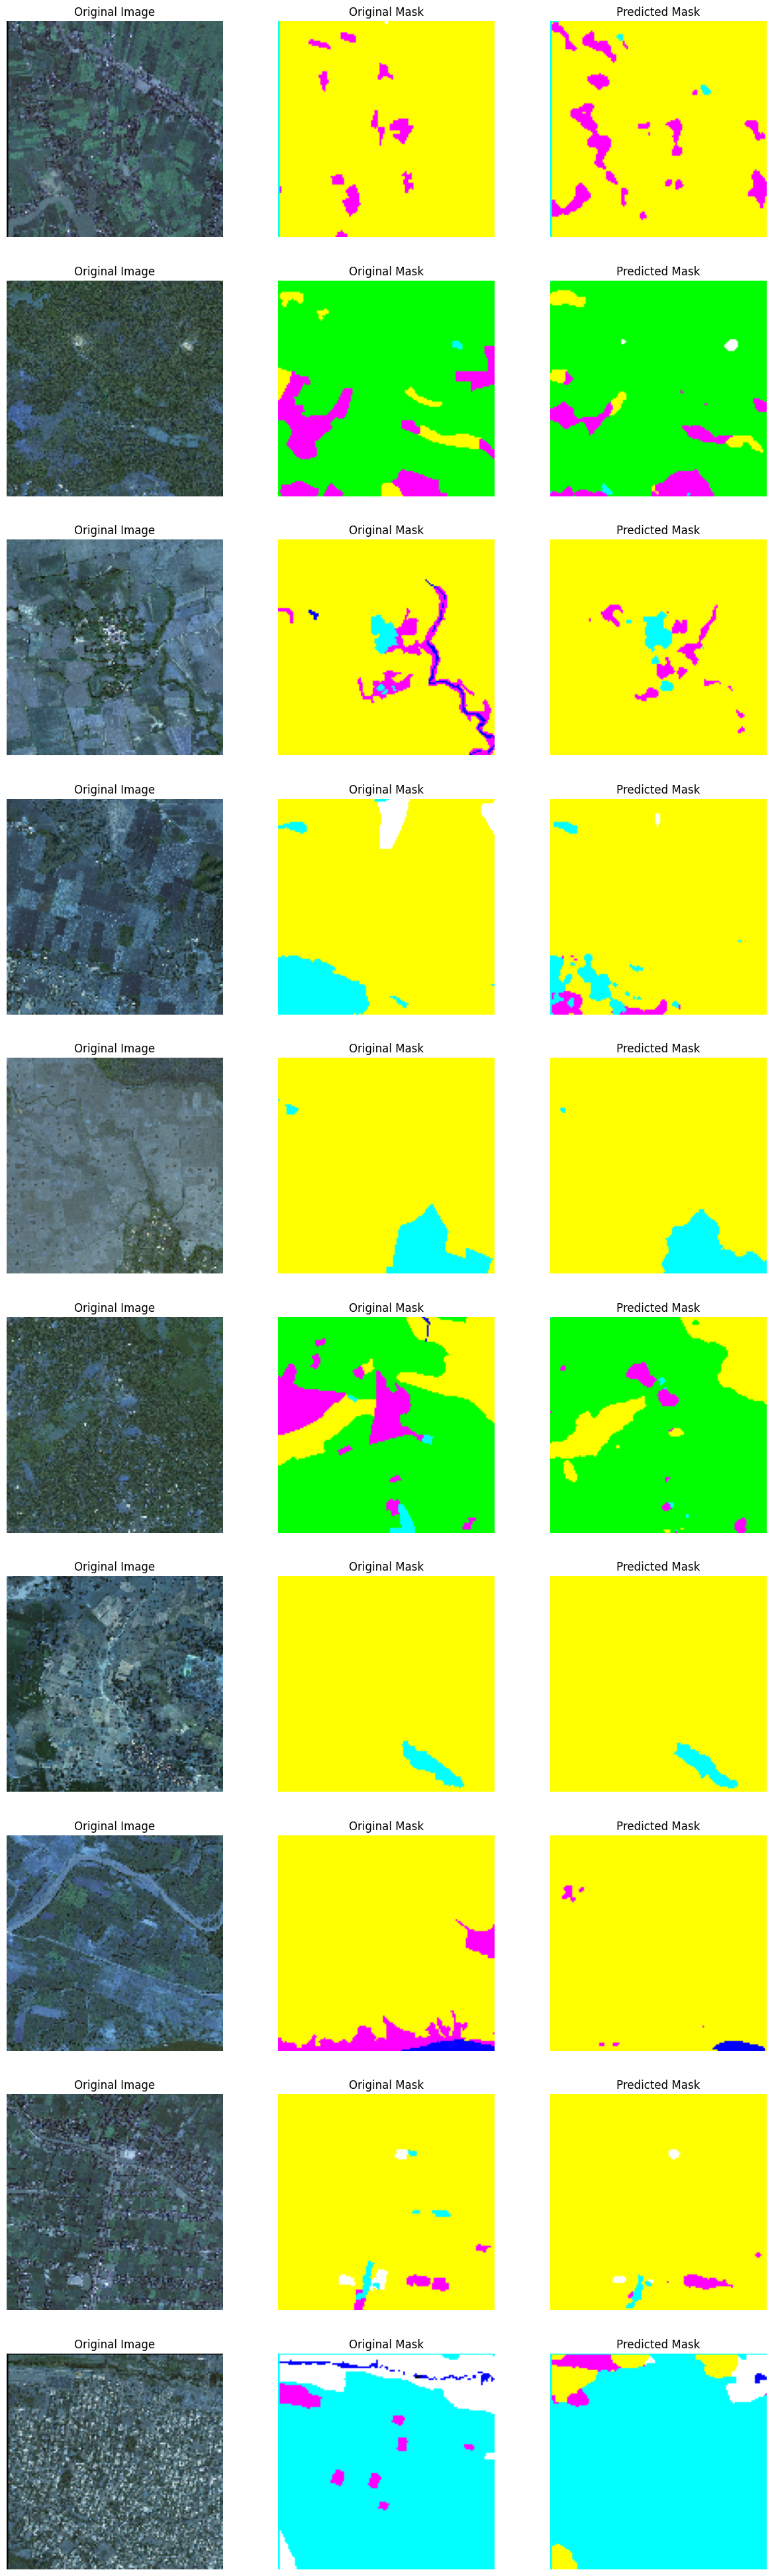

In [ ]:
def visualize_predictions(model, test_loader, class_to_color, device, num_samples=10):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

    # Ensure axes are always a 2D array
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    sample_count = 0

    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if sample_count >= num_samples:
                break

            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for j in range(images.size(0)):
                if sample_count >= num_samples:
                    break

                # Original image
                original_image = images[j].cpu().numpy().transpose((1, 2, 0))

                # Original mask
                original_mask = masks[j].cpu().numpy()
                original_mask_rgb = class_indices_to_rgb(original_mask, class_to_color)

                # Predicted mask
                predicted_mask = predicted[j].cpu().numpy()
                predicted_mask_rgb = class_indices_to_rgb(predicted_mask, class_to_color)

                # Plotting
                axes[sample_count, 0].imshow(original_image)
                axes[sample_count, 0].set_title('Original Image')
                axes[sample_count, 0].axis('off')

                axes[sample_count, 1].imshow(original_mask_rgb)
                axes[sample_count, 1].set_title('Original Mask')
                axes[sample_count, 1].axis('off')

                axes[sample_count, 2].imshow(predicted_mask_rgb)
                axes[sample_count, 2].set_title('Predicted Mask')
                axes[sample_count, 2].axis('off')

                sample_count += 1

visualize_predictions(model, test_loader, class_to_color, device, num_samples=10)


This part of the code is provided for manual testing of the model. By entering the appropriate path to an image, it is possible to predict the mask for the given image and simultaneously open the corresponding real mask to see the similarity between them.

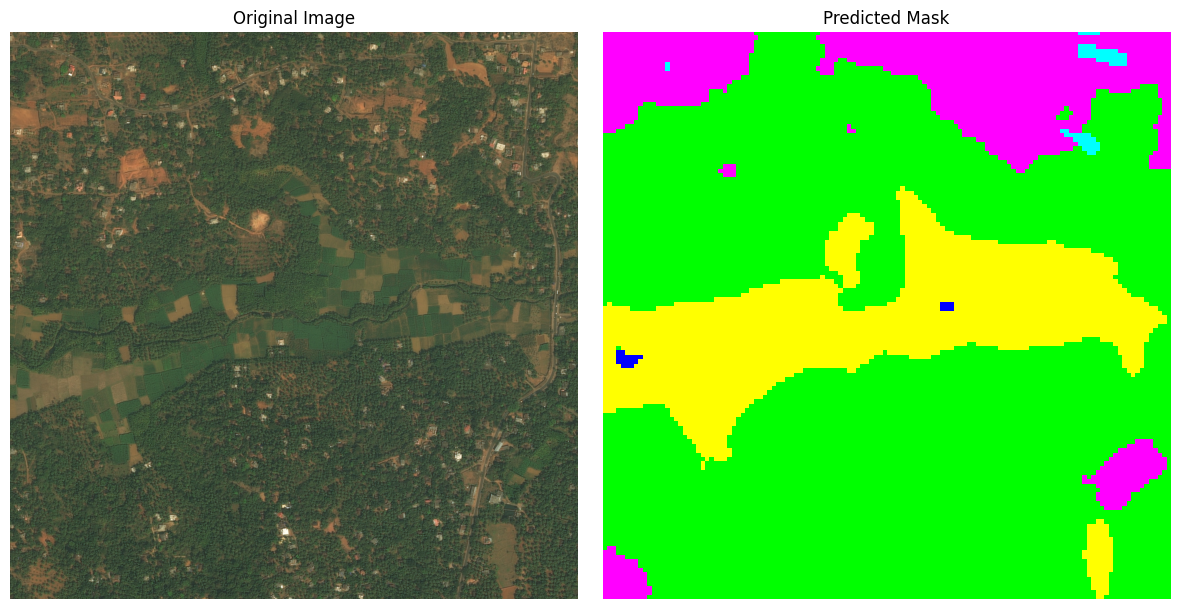

In [ ]:
# Define a mapping from class indices to RGB values
class_to_color = {
    0: (0, 255, 255),   # Urban land
    1: (255, 255, 0),   # Agriculture land
    2: (255, 0, 255),   # Rangeland
    3: (0, 255, 0),     # Forest land
    4: (0, 0, 255),     # Water
    5: (255, 255, 255), # Barren land
    6: (0, 0, 0)        # Unknown
}

# Function to convert class indices to RGB
def class_indices_to_rgb(mask_indices, class_to_color):
    height, width = mask_indices.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)
    for cls, rgb in class_to_color.items():
        rgb_image[mask_indices == cls] = rgb
    return rgb_image

# Function to preprocess image for inference
def preprocess_image(image_path, img_height, img_width):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return torch.tensor(img, dtype=torch.float32)


image_path = './deepglobe_dataset/train/291214_sat.jpg'
img_height, img_width = 128, 128

# Preprocess the image
input_image = preprocess_image(image_path, img_height, img_width)
input_image = input_image.to(device)

# Perform inference
with torch.no_grad():
    output_mask = model(input_image)

# Post-process the output mask (if needed)
predicted_class = torch.argmax(output_mask, dim=1).cpu().numpy()[0]

# Convert class indices to RGB
predicted_rgb = class_indices_to_rgb(predicted_class, class_to_color)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_rgb)
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()